<a href="https://colab.research.google.com/github/abderrazzakchabab/ki-initiative/blob/main/S3_to_Elasticsearch_with_Unstructured.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transforming Unstructured Data from an AWS S3 bucket into RAG-Ready Data in Elasticsearch

In this quick tutorial we'll ingest PDFs from an S3 bucket,transform them into a normalized JSON with Unstructured, which we will then chunk, embed and load into Elasticsearch.

Prerequisites:

A. Get your [Unstructured Serverless API key](https://unstructured.io/api-key-hosted). It comes with a 14-day trial, and a cap of 1000 pages/day.

B. Create an AWS S3 bucket, and populate it with PDFs of choice. Make sure to note down your credentials.

C. Sign up for [Elasticsearch cloud](https://www.elastic.co/cloud) and note down your credentials.

D. Install the necessary libraries:

In [ ]:
!pip install -q -U "unstructured-ingest[s3, pdf, elasticsearch, embed-huggingface]" python-dotenv

## Load env variables

In this example we're loading the environment variables with all the secrets from a file in Google Drive. For this, we mount the Google Drive (if you do the same, note that there will be a pop up asking you to connect to your Google drive).
Once the drive is mounted, we load the env variables from a `.env` file. If you have another preferred method for loading env variables, go ahead and use it :)

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import dotenv

dotenv.load_dotenv('/content/drive/MyDrive/.env')

True

## Create Elasticsearch index

Before we start working on data preprocessing, let's create an Elasticsearch index that will be the destination for the processed documents.

While Elasticsearch supports dynamic mapping, it's considered a best practice to define the mapping before loading the data. You can find a sample mapping for Elasticsearch in [Unstrutured documentation](https://docs.unstructured.io/api-reference/ingest/destination-connector/elasticsearch#vector-search-sample-mapping). Copy it into the `elasticsearch_elements_mappings.json` file to use in this example.
The only value you may need to modify is `dims` for the `embeddings`. The number of dimensions depends on the embeddings model you choose to use. By default, it's 384. For this example to work, change it to 768.

In [ ]:
import json
from elasticsearch import Elasticsearch

CLOUD_ID = os.getenv("ELASTICSEARCH_CLOUD_ID")
API_KEY = os.getenv("ELASTICSEARCH_API_KEY")
INDEX_NAME = os.getenv("ELASTICSEARCH_INDEX_NAME")

MAPPING_PATH = "elasticsearch_elements_mappings.json"

with open(MAPPING_PATH) as f:
    mappings = json.load(f)


es = Elasticsearch(cloud_id=CLOUD_ID,
                   api_key=API_KEY)

# Creating an Elasticsearch index
response = es.options(max_retries=5).indices.create(index=INDEX_NAME, mappings=mappings)
if response.meta.status != 200:
    raise RuntimeError("failed to create index")

es.indices.refresh(index=INDEX_NAME)
response = es.cat.count(index=INDEX_NAME, format="json")

print("Succesfully created an Elasticsearch index")

Succesfully created an Elasticsearch index


## PDFs ingestion and preprocessing pipeline


In [ ]:
from unstructured_ingest.v2.interfaces import ProcessorConfig
from unstructured_ingest.v2.pipeline.pipeline import Pipeline
from unstructured_ingest.v2.processes.chunker import ChunkerConfig
from unstructured_ingest.v2.processes.connectors.fsspec.s3 import (
    S3ConnectionConfig,
    S3DownloaderConfig,
    S3IndexerConfig,
    S3AccessConfig,
)
from unstructured_ingest.v2.processes.connectors.elasticsearch import (
    ElasticsearchConnectionConfig,
    ElasticsearchUploaderConfig,
    ElasticsearchAccessConfig,
)
from unstructured_ingest.v2.processes.embedder import EmbedderConfig
from unstructured_ingest.v2.processes.partitioner import PartitionerConfig
from unstructured_ingest.v2.processes.connectors.elasticsearch import ElasticsearchUploadStagerConfig


Unstructured ingestion and transformation pipeline is compiled from a number of necessary configs. These don't have to be in the exact same order.

* `ProcessorConfig`: defines general processing behavior
* `S3IndexerConfig`, `S3DownloaderConfig`, `S3ConnectionConfig`: control data ingestion from S3, including source location, and authentication options.
* `PartitionerConfig`: describes partitioning behavior. Here we only set up authentication for the Unstructured API, but you can also control [partitioning parameters](https://docs.unstructured.io/api-reference/ingest/ingest-configuration/partition-configuration) such as partitioning strategy through this config. We're going with the defaults.  
* `ChunkerConfig`: defines the chunking strategy, and chunk sizes.
* `EmbedderConfig`: sets up connection to an embedding model provider to generate embeddings for data chunks.
* `ElasticsearchUploadStagerConfig`, `ElasticsearchConnectionConfig`, `ElasticsearchUploaderConfig`: control the final step of the pipeline - data loading into Elasticsearch.

In [ ]:
Pipeline.from_configs(
    context=ProcessorConfig(tqdm=True, num_processes=20),
    indexer_config=S3IndexerConfig(remote_url=os.getenv("AWS_S3_NAME")),
    downloader_config=S3DownloaderConfig(),
    source_connection_config=S3ConnectionConfig(
        access_config=S3AccessConfig(
            key=os.getenv("AWS_KEY"),
            secret=os.getenv("AWS_SECRET"))
    ),
    partitioner_config=PartitionerConfig(
        partition_by_api=True,
        api_key=os.getenv("UNSTRUCTURED_API_KEY"),
        partition_endpoint=os.getenv("UNSTRUCTURED_URL"),
    ),
    chunker_config=ChunkerConfig(
        chunking_strategy="by_title",
        chunk_max_characters=512,
        chunk_combine_text_under_n_chars=200,
    ),
    embedder_config=EmbedderConfig(
        embedding_provider="langchain-huggingface",
        embedding_model_name="BAAI/bge-base-en-v1.5",
    ),
    stager_config=ElasticsearchUploadStagerConfig(index_name=INDEX_NAME),
    destination_connection_config=ElasticsearchConnectionConfig(
        access_config=ElasticsearchAccessConfig(api_key=API_KEY),
        cloud_id=CLOUD_ID,
    ),
    uploader_config=ElasticsearchUploaderConfig(index_name=INDEX_NAME),
).run()

Once you run the pipeline, you should see your documents in the corresponding index in your Elastic Cloud.

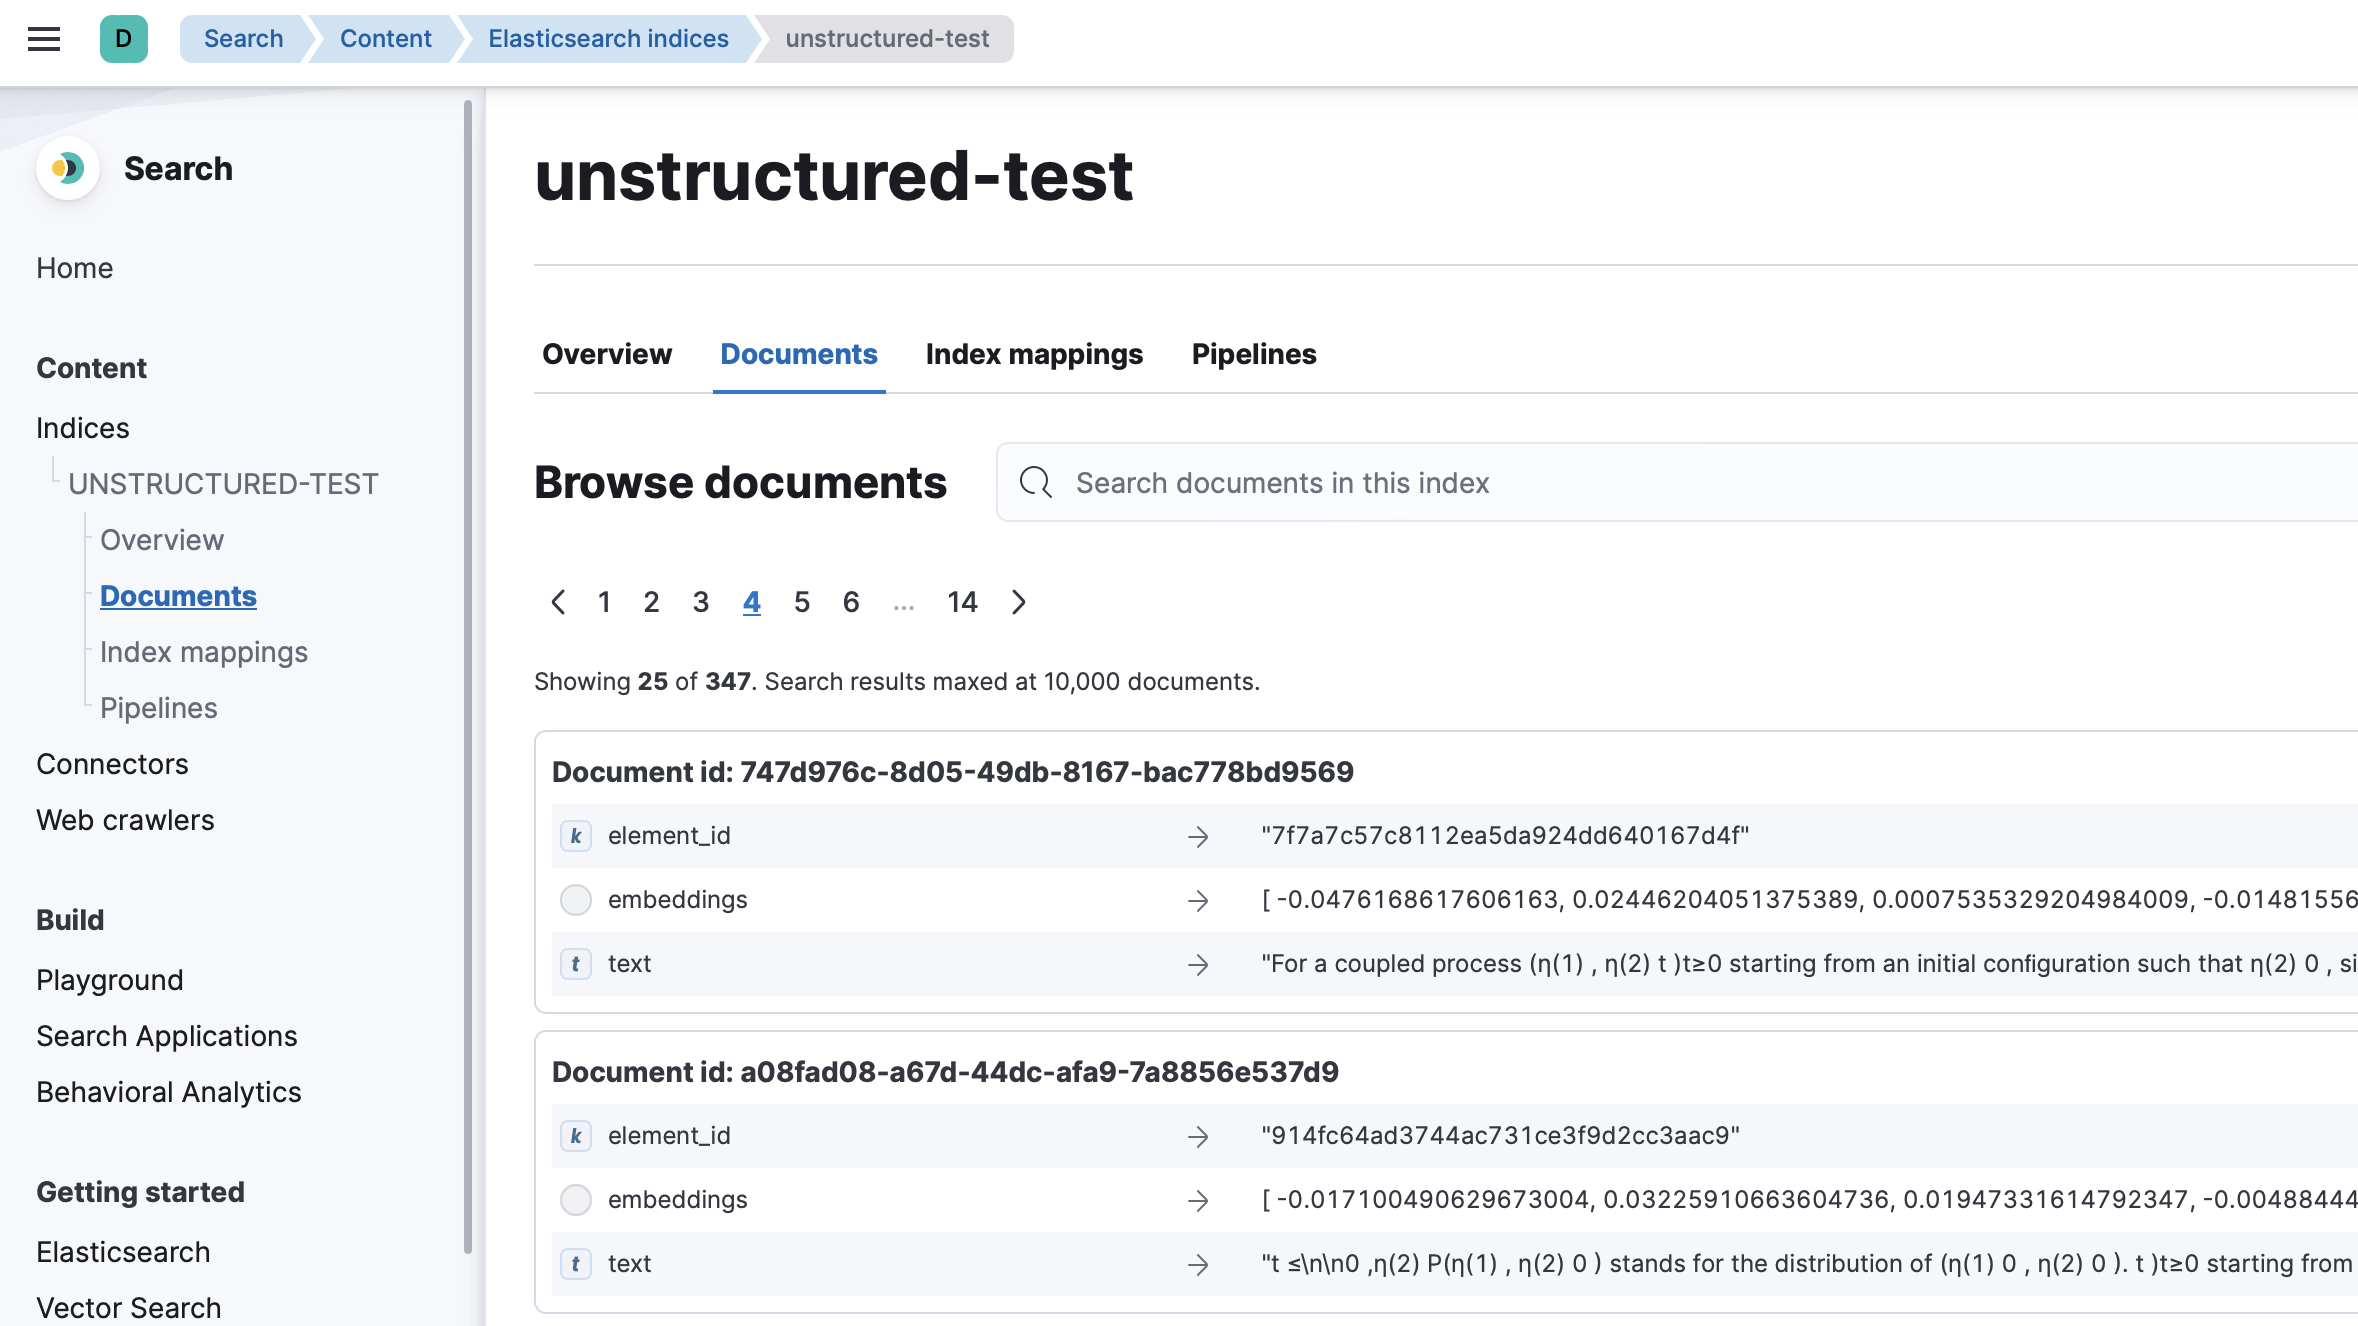